# InCURA Tutorial - Identify Driver TFs

## Identify TFs that are enriched in the binding sites of genes in the InCURA clusters


### Import of packages

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import scanpy as sc
import scipy.cluster.hierarchy as sch
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import re
from datetime import datetime

# Needed for some plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Create a timestamp string
timestamp = datetime.now().strftime("%Y%m%d")

pd.set_option('display.max_rows', 500)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
custom_colors = ['#e8ba41', '#b1a73e', '#b93c6d', '#b4d6e7', 'grey']

### Load data

In [3]:
# Set path variable
path = 'tutorial_data/'

In [6]:
count_df = pd.read_csv(path + f'count_df_kmeans_labels_k4_{timestamp}.tsv', sep='\t', index_col=0)
mat = pd.read_csv(path + 'binary_matrix.tsv', sep='\t', index_col=0)

### Plot Driver TFs in each cluster

In [7]:
def tfbs_cluster_enrichment(binary_matrix, cluster_labels, pval_threshold=0.05):
    """
    Perform TFBS enrichment analysis for clusters using binary TFBS data.
    
    Parameters:
    - binary_matrix: DataFrame where rows are genes, columns are TFBSs (binary 0/1).
    - cluster_labels: Series indicating cluster assignment for each gene.
    - pval_threshold: Threshold for corrected p-values.
    
    Returns:
    - DataFrame with significant TFBSs per cluster.
    """
    unique_clusters = cluster_labels.unique()
    enrichment_results = []

    for cluster_label in unique_clusters:
        # Separate cluster-specific and background genes
        cluster_genes = binary_matrix[cluster_labels == cluster_label]
        background_genes = binary_matrix[cluster_labels != cluster_label]

        cluster_size = len(cluster_genes)
        background_size = len(background_genes)

        for tfbs in binary_matrix.columns:
            cluster_tfbs_count = cluster_genes[tfbs].sum()
            background_tfbs_count = background_genes[tfbs].sum()

            # Fisher's exact test
            contingency_table = [
                [cluster_tfbs_count, cluster_size - cluster_tfbs_count],
                [background_tfbs_count, background_size - background_tfbs_count],
            ]
            _, p_value = fisher_exact(contingency_table)

            enrichment_results.append({
                'TFBS': tfbs,
                'Cluster': cluster_label,
                'p_value': p_value
            })

    # Convert to DataFrame
    enrichment_df = pd.DataFrame(enrichment_results)

    # Correct for multiple testing
    enrichment_df['corrected_pval'] = multipletests(enrichment_df['p_value'], method='fdr_bh')[1]

    # Filter significant results
    significant_results = enrichment_df[enrichment_df['corrected_pval'] < pval_threshold]
    
    return significant_results


In [11]:
import warnings
warnings.filterwarnings('ignore')

enrichment_results = tfbs_cluster_enrichment(mat, count_df['Cluster'], pval_threshold=0.05)

tfbs_frequencies = enrichment_results.groupby('TFBS')['Cluster'].count()
ubiquitous_tfbs = tfbs_frequencies[tfbs_frequencies > 1].index
enrichment_results = enrichment_results[~enrichment_results['TFBS'].isin(ubiquitous_tfbs)]

enrichment_results.groupby('Cluster').apply(lambda x: x.nsmallest(10, 'p_value'))

TFBS  Cluster       p_value  corrected_pval
Cluster                                                   
0       512    FLI1        0  4.032127e-03    2.403464e-02
        573   MLXIP        0  5.826579e-03    3.342038e-02
        623    RORA        0  6.414633e-03    3.633631e-02
        531    HIC1        0  8.184711e-03    4.390857e-02
        658   TEAD3        0  9.236284e-03    4.841087e-02
        461  ARID5A        0  9.317442e-03    4.855718e-02
1       864    SOX4        1  5.773180e-13    9.402036e-12
        772    IRF1        1  5.513409e-12    8.669361e-11
        773    IRF2        1  3.431805e-08    4.471152e-07
        750   FOXO4        1  1.051005e-07    1.295293e-06
        793    MAFK        1  2.885177e-04    2.370524e-03
        780    IRF9        1  3.128965e-04    2.525324e-03
        701  BCL11B        1  3.447533e-04    2.758026e-03
        894  THAP11        1  3.607337e-04    2.810637e-03
        778    IRF7        1  3.861068e-04    2.959071e-03
        797   MEF2A        1  5.399360e-04    4.003428e-03
2       84     HSF2        2  1.857730e-04    1.583411e-03
        34     E2F2        2  1.079055e-03    7.399235e-03
        223  ZFP410        2  7.327801e-03    4.096729e-02
        133    NFYA        2  7.366925e-03    4.096729e-02
3       238    ATF2        3  5.010180e-04    3.745315e-03
        299   GLIS2        3  7.183532e-04    5.283372e-03
        381  POU6F1        3  9.189299e-04    6.446647e-03
        237    ATF1        3  9.266067e-04    6.450880e-03
        254   CREB1        3  1.680721e-03    1.087104e-02
        423  STAT5B        3  2.679882e-03    1.629368e-02
        241    ATF7        3  2.829644e-03    1.709030e-02
        311    HSF1        3  5.388569e-03    3.170565e-02

In [12]:
# Optionally save results
enrichment_results.to_csv(path + f'enrichment_results_{timestamp}.tsv', sep='\t', index=False)

In [13]:
# Keep only top 10 TFBS per cluster
enrichment_results = enrichment_results[enrichment_results['TFBS'].isin(enrichment_results.groupby('Cluster').apply(lambda x: x.nsmallest(10, 'p_value'))['TFBS'])]

In [18]:
# Reformat and sort enrichment results for plotting
enrichment_results.index = enrichment_results.TFBS
pivot_results = enrichment_results.pivot(index='TFBS', columns='Cluster', values='corrected_pval')
pivot_results = pivot_results.sort_values(by=[0,1,2,3])

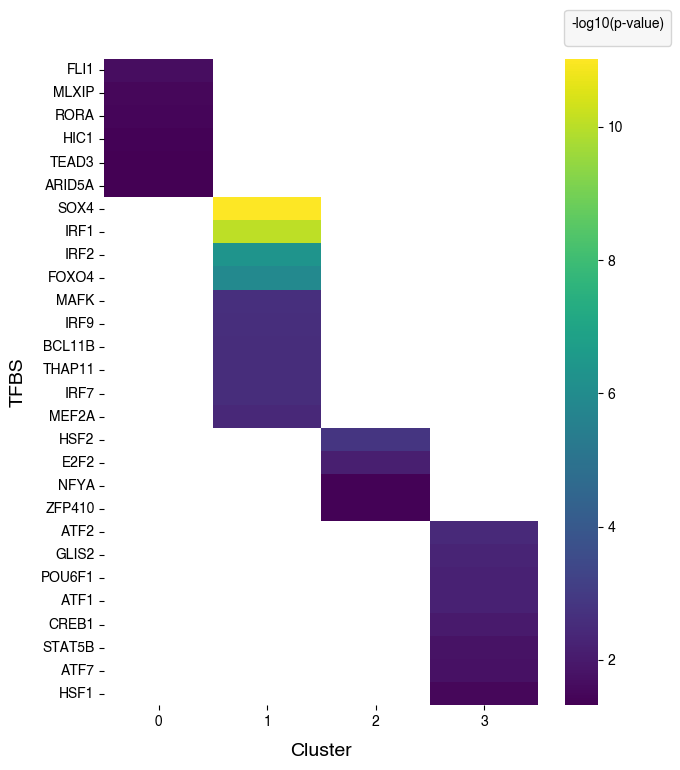

In [19]:
# Plot heatmap of -log10(corrected p-values)
plt.figure(figsize=(7, max(6, 0.3 * len(pivot_results)))) 
ax = plt.axes(frameon=False)

sns.heatmap(-np.log10(pivot_results), cmap='viridis', annot=False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlabel('Cluster', fontsize=14, labelpad=10)
plt.ylabel('TFBS', fontsize=14, labelpad=10)
plt.legend(title='-log10(p-value)', loc=(1.06,1.02), fontsize=12, facecolor='whitesmoke')

plt.savefig(path + f'heatmap_enrichTF_per_cluster_k5_{timestamp}.svg', bbox_inches='tight')
plt.show()